## Assignment 7: RDS Database

Cloud Computing
Group 3
Nelson Foster & Bill Grieser

This Jupyter Notebook shows the steps we carried out to perform Assignment 7.

### Show the database definition

This is a screen shot of the AWS console for the database we are using in this assignment.

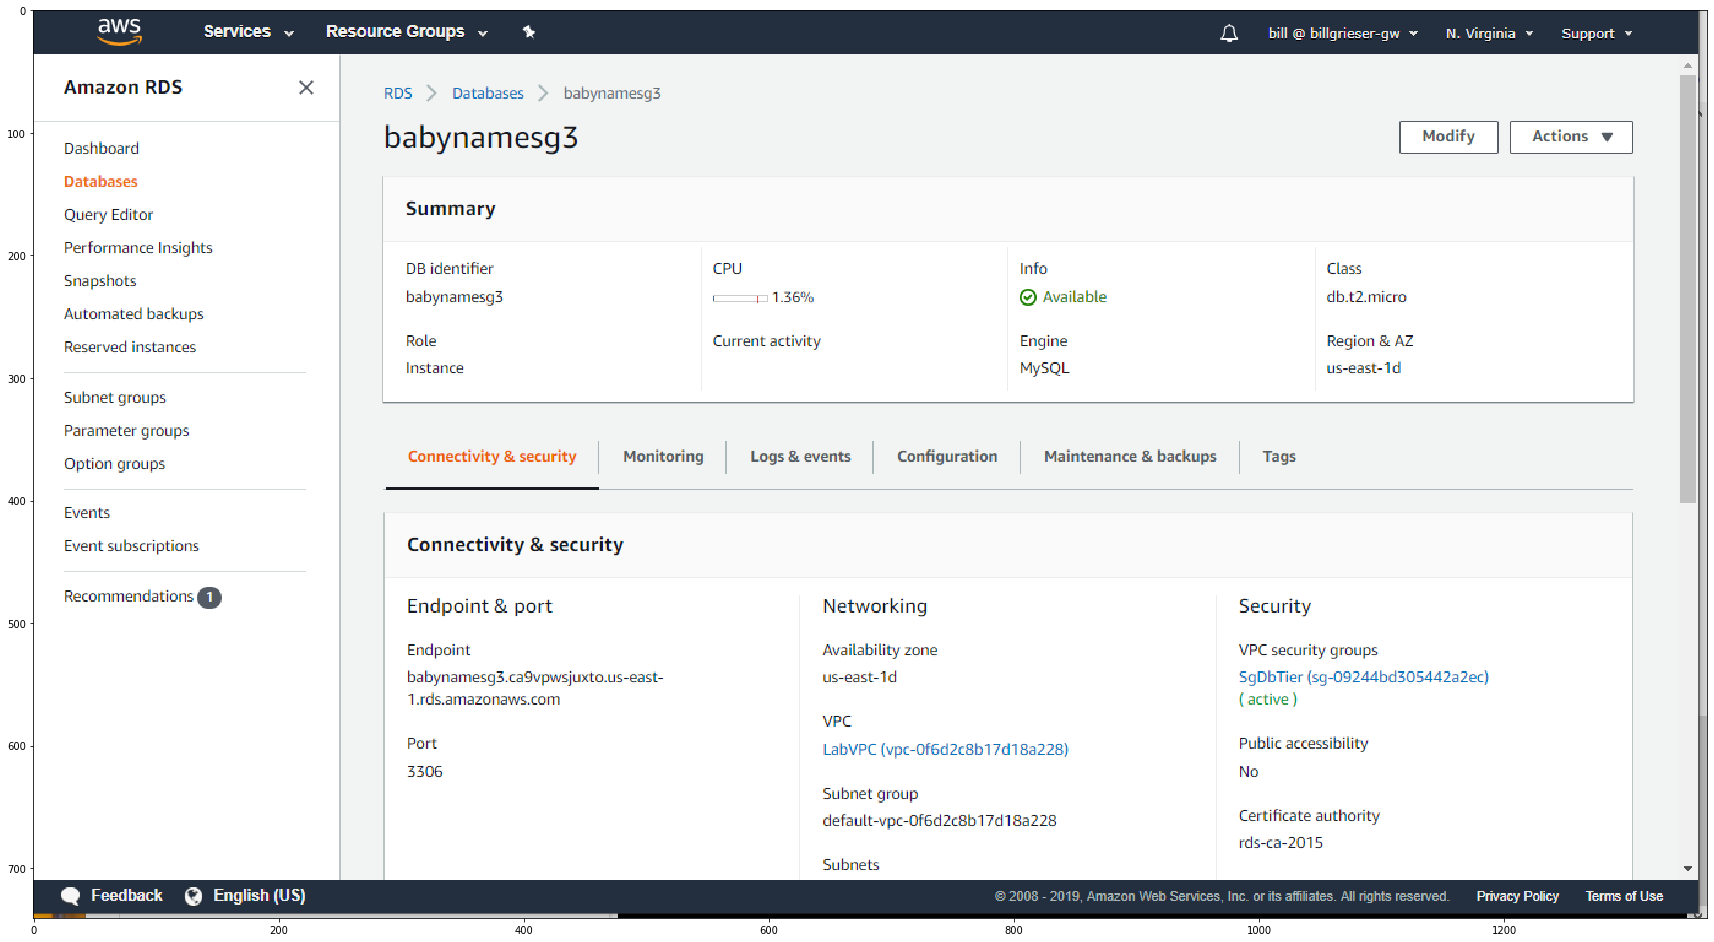

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

im = mpimg.imread("RDS.png")
plt.figure(figsize=(30,20))
plt.imshow(im)
plt.show()

### Import needed libraries and check the current directory

In [2]:
import os
import zipfile
import pandas as pd
import glob

NAMES_DIR = "baby_names"

os.getcwd()

'/home/ec2-user/Notebooks'

### Download the zipfile with the names from the source

Use Linux command to get the file, erasing previos versions downloaded.

In [3]:
!rm -f names.zip
!wget -nc https://www.ssa.gov/oact/babynames/names.zip

--2019-06-20 03:11:13--  https://www.ssa.gov/oact/babynames/names.zip
Resolving www.ssa.gov (www.ssa.gov)... 137.200.39.19, 2001:1930:e03::aaaa
Connecting to www.ssa.gov (www.ssa.gov)|137.200.39.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7200451 (6.9M) [application/zip]
Saving to: ‘names.zip’

names.zip           100%[===================>]   6.87M  11.8MB/s    in 0.6s    

2019-06-20 03:11:13 (11.8 MB/s) - ‘names.zip’ saved [7200451/7200451]



### Unzip the zip file 

Use the python zipfile library to unzip the files into a directory, then display the tail of the directory list.

In [4]:
zf = zipfile.ZipFile("names.zip")

# Make sure we have the folder to hold each year's file
if not os.path.exists(NAMES_DIR):
    os.makedirs(NAMES_DIR)
    
# Unzip
zf.extractall(path=NAMES_DIR)

!ls -l $NAMES_DIR | tail

-rw-rw-r-- 1 ec2-user ec2-user 448033 Jun 20 03:11 yob2009.txt
-rw-rw-r-- 1 ec2-user ec2-user 439608 Jun 20 03:11 yob2010.txt
-rw-rw-r-- 1 ec2-user ec2-user 437159 Jun 20 03:11 yob2011.txt
-rw-rw-r-- 1 ec2-user ec2-user 435049 Jun 20 03:11 yob2012.txt
-rw-rw-r-- 1 ec2-user ec2-user 428768 Jun 20 03:11 yob2013.txt
-rw-rw-r-- 1 ec2-user ec2-user 428107 Jun 20 03:11 yob2014.txt
-rw-rw-r-- 1 ec2-user ec2-user 426134 Jun 20 03:11 yob2015.txt
-rw-rw-r-- 1 ec2-user ec2-user 424451 Jun 20 03:11 yob2016.txt
-rw-rw-r-- 1 ec2-user ec2-user 418588 Jun 20 03:11 yob2017.txt
-rw-rw-r-- 1 ec2-user ec2-user 411162 Jun 20 03:11 yob2018.txt


### Connect to the RDS instance

In [5]:
import pymysql

# Connect to DB -- allow local infile to load the data
db = pymysql.connect("babynamesg3.ca9vpwsjuxto.us-east-1.rds.amazonaws.com","admin","usopen2019","babynames", local_infile=True )

# Test the connection
with db.cursor() as cursor:

    cursor.execute("SELECT VERSION()")
    data = cursor.fetchone()

print ("Database version : {0}".format(data[0]))

Database version : 5.7.22-log


### Create DB table if needed, Clear it if it exists

In [6]:
create_string = """
CREATE TABLE IF NOT EXISTS nametally (
   BabyName VARCHAR(50) NOT NULL, 
   Sex VARCHAR(5) NOT NULL, 
   Births INT NOT NULL, 
   Year INT NOT NULL
);
"""

with db.cursor() as cursor:
    
    cursor.execute("DROP TABLE IF EXISTS nametally;")
    db.commit()

    cursor.execute(create_string)
    db.commit()

    clear_string = "DELETE FROM nametally;"
    cursor.execute(clear_string)

    db.commit()

### Load each of the names files into the database

For each file of baby nanes, figure out the year of the file by extracting it from the file name. Then use MySql's LOAD DATA LOCAL INFILE command to load the values of the file into the database table. Use the file name from the file to set the Year column in the table.

In [7]:
insert_sql = """
LOAD DATA LOCAL INFILE '{0}' INTO TABLE nametally
FIELDS TERMINATED BY ',' 
LINES TERMINATED BY '\n'  
(BabyName, Sex, Births)
SET year={1};
"""

with db.cursor() as cursor:

    fnames = glob.glob(os.path.join(NAMES_DIR, "yob*.txt"))
    fnames = sorted(fnames)
    
    # Read all the names files
    for fname in fnames:

        year = fname[len(NAMES_DIR)+4: -4]
        print("Working on year:", year)

        # Ask mysql to load the csv file intp the database table
        cursor.execute(insert_sql.format(fname, year))

        db.commit()

Working on year: 1880
Working on year: 1881
Working on year: 1882
Working on year: 1883
Working on year: 1884
Working on year: 1885
Working on year: 1886
Working on year: 1887
Working on year: 1888
Working on year: 1889
Working on year: 1890
Working on year: 1891
Working on year: 1892
Working on year: 1893
Working on year: 1894
Working on year: 1895
Working on year: 1896
Working on year: 1897
Working on year: 1898
Working on year: 1899
Working on year: 1900
Working on year: 1901
Working on year: 1902
Working on year: 1903
Working on year: 1904
Working on year: 1905
Working on year: 1906
Working on year: 1907
Working on year: 1908
Working on year: 1909
Working on year: 1910
Working on year: 1911
Working on year: 1912
Working on year: 1913
Working on year: 1914
Working on year: 1915
Working on year: 1916
Working on year: 1917
Working on year: 1918
Working on year: 1919
Working on year: 1920
Working on year: 1921
Working on year: 1922
Working on year: 1923
Working on year: 1924
Working on

### Show a sample of the data from the database

Pick a sample year and retrieve data from the year. Put it in a pandas dataframe to display (since Jupyter does a nice job displaying dataframes).

In [8]:
with db.cursor(pymysql.cursors.DictCursor) as cursor:
    cursor.execute("SELECT * FROM nametally WHERE YEAR = 2001 ORDER BY Births DESC LIMIT 100")
    data = cursor.fetchall()
printme = pd.DataFrame(data)
printme

,BabyName,Births,Sex,Year
0,Jacob,32545,M,2001
1,Michael,29683,M,2001
2,Matthew,26808,M,2001
3,Joshua,26015,M,2001
4,Emily,25057,F,2001
5,Christopher,23126,M,2001
6,Nicholas,22845,M,2001
7,Andrew,22411,M,2001
8,Madison,22164,F,2001
9,Joseph,22011,M,2001


### Plot births by year

Execute a query to calculate the number of births per year in total and by sex and plot the results.

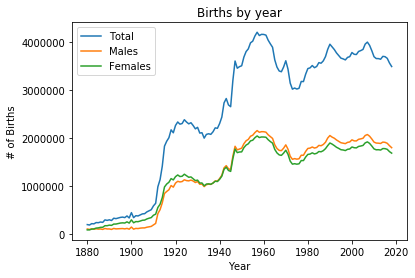

In [9]:
query_sql = """
SELECT  Year, SUM(Births) as "Total", 
    SUM(CASE WHEN Sex = 'M' THEN Births ELSE 0 END) as "Male",
    SUM(CASE WHEN Sex = 'F' THEN Births ELSE 0 END) as "Female"
FROM nametally GROUP BY Year;
"""
with db.cursor(pymysql.cursors.DictCursor) as cursor:
    cursor.execute(query_sql)
    results = pd.DataFrame(cursor.fetchall())
 
plt.plot("Year", "Total", data=results, label="Total")
plt.plot("Year", "Male", data=results, label="Males")
plt.plot("Year", "Female", data=results, label="Females")
plt.title("Births by year")
plt.xlabel("Year")
plt.ylabel("# of Births")
plt.legend()
plt.show()

### Show the tables in the database and the definition of the table we are using
This should match the definition of the CREATE TABLE statement used above to create the table.

In [10]:
!echo "show tables;;" > show.txt
!echo "desc nametally;" >> show.txt
!mysql -h babynamesg3.ca9vpwsjuxto.us-east-1.rds.amazonaws.com --show-warnings --user admin --password=usopen2019 babynames < show.txt

Tables_in_babynames
nametally
Field	Type	Null	Key	Default	Extra
BabyName	varchar(50)	NO		NULL	
Sex	varchar(5)	NO		NULL	
Births	int(11)	NO		NULL	
Year	int(11)	NO		NULL	
